*[Fil d'étincelles](https://atelier-mediatheque.rlv.eu/agenda/fil-detincelles)*

# Dans la peau d'un data scientist

In [1]:
import numpy
import pandas
import matplotlib.pyplot
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler

## 1. Introduction à Python

Python est un interpréteur : il exécute une à une chaque instruction qu'on lui donne. Comme de nombreux langages de programmation, il utilise des *variables*, des sortes de boîtes dans lesquelles nous pouvons mémoriser un nombre ou un texte, et le modifier. Python permet également d'effectuer des manipulations un peu plus complexes, comme les boucles.

In [2]:
2 + 3

5

In [3]:
print("Bonjour")

Bonjour


In [4]:
i = 10
print(i)

10


In [5]:
i = i + 4
print(i)

14


In [6]:
i = 1
while i <= 10:
    print("Tour", i)
    i += 1

Tour 1
Tour 2
Tour 3
Tour 4
Tour 5
Tour 6
Tour 7
Tour 8
Tour 9
Tour 10


## 2. Les données

### 2.1. Chargement et premier nettoyage

In [7]:
tableau = pandas.read_csv("input/type_couvert.csv")

encodeur = LabelEncoder()
tableau["Type_Couvert"] = encodeur.fit_transform(tableau["Type_Couvert"])

def fusionner_colonnes(colonne, taille):
    tableau[colonne] = 0
    for i in range(1, taille):
        tableau[colonne] += i * tableau[colonne + str(i)]
    tableau.drop(columns=[colonne + str(i) for i in range(1, taille)], inplace=True)

fusionner_colonnes("Sol", 41)
fusionner_colonnes("Zone", 5)

tableau

,Altitude,Orientation,Pente,Distance_Horizontale_Eau,Distance_Verticale_Eau,Distance_Route,Ensoleillement_Matin,Ensoleillement_Midi,Ensoleillement_Aprem,Distance_Feu,Type_Couvert,Sol,Zone
0,2596,51,3,258,0,510,221,232,148,6279,4,29,1
1,2590,56,2,212,-6,390,220,235,151,6225,4,29,1
2,2804,139,9,268,65,3180,234,238,135,6121,1,12,1
3,2785,155,18,242,118,3090,238,238,122,6211,1,30,1
4,2595,45,2,153,-1,391,220,234,150,6172,4,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,2,2,3
581008,2391,152,19,67,12,95,240,237,119,845,2,2,3
581009,2386,159,17,60,7,90,236,241,130,854,2,2,3
581010,2384,170,15,60,5,90,230,245,143,864,2,2,3


### 2.2. Provenance

Ces données proviennent de la [Roosevelt National Forest]([https://earth.google.com/earth/d/1Yr-EOzbPUiu_ReAvI55S2wrmWIj02ZqS?usp=sharing](https://earth.google.com/earth/d/1Yr-EOzbPUiu_ReAvI55S2wrmWIj02ZqS?usp=sharing)), plus précisément de quatre zone :

1. Rawah Wilderness Area
2. Neota Wilderness Area
3. Comanche Peak Wilderness Area
4. Cache la Poudre Wilderness Area

In [8]:
tableau_zones = tableau.groupby(by="Zone").mean()
tableau_zones["ZoneNom"] = [
    "Rawah Wilderness",
    "Neota Wilderness",
    "Comanche Peak Wilderness",
    "Cache la Poudre Wilderness"
]
tableau_zones.drop(columns=["Type_Couvert"], inplace=True)
tableau_zones.set_index("ZoneNom", inplace=True)
tableau_zones

,Altitude,Orientation,Pente,Distance_Horizontale_Eau,Distance_Verticale_Eau,Distance_Route,Ensoleillement_Matin,Ensoleillement_Midi,Ensoleillement_Aprem,Distance_Feu,Sol
ZoneNom,,,,,,,,,,,
Rawah Wilderness,3000.267286,138.280273,12.157292,246.553333,34.745744,3134.408055,218.117199,223.948017,137.644385,2538.703600,26.013037
Neota Wilderness,3245.727814,182.565118,12.937893,320.294104,44.238690,1008.166477,211.435484,226.917581,148.232967,2136.523524,27.848682
Comanche Peak Wilderness,2980.554471,165.189549,15.173786,298.923272,56.153171,1937.118438,209.084606,224.412320,146.478482,1562.401351,24.719451
Cache la Poudre Wilderness,2294.106038,191.156406,21.443438,187.536221,63.815733,733.017123,191.578040,208.474870,145.297501,778.649021,7.453122


### 2.3. Visualisation de quelques *features*

In [9]:
CLASSES = [
    "Épicéa/Sapin",
    "Pin tordu",
    "Pin jaune de l'ouest",
    "Peuplier d'Amérique/Saule",
    "Tremble",
    "Sapin de Douglas",
    "Krummholz"
]

def graphe_dispersion(data_frame, feature_x, feature_y, w=12, h=6):
    fig, ax = matplotlib.pyplot.subplots(figsize=(w, h))
    scatter = ax.scatter(
        data_frame[feature_x],
        data_frame[feature_y],
        c=data_frame["Type_Couvert"],
        alpha=0.2,
        s=20,
        cmap=ListedColormap([
            "orange",
            "red",
            "green",
            "blue",
            "yellow",
            "cyan",
            "magenta",
            "black"
        ]))
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=CLASSES,
        loc="upper right"
    )

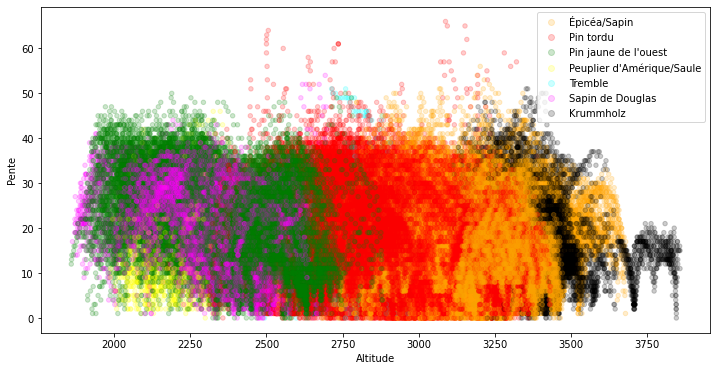

In [10]:
graphe_dispersion(tableau, "Altitude", "Pente")

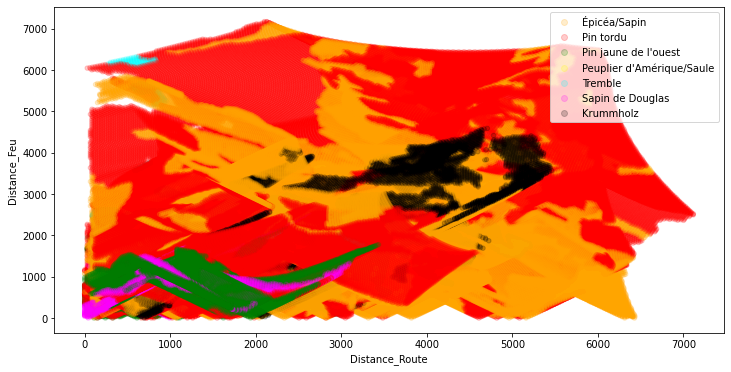

In [11]:
graphe_dispersion(tableau, "Distance_Route", "Distance_Feu")

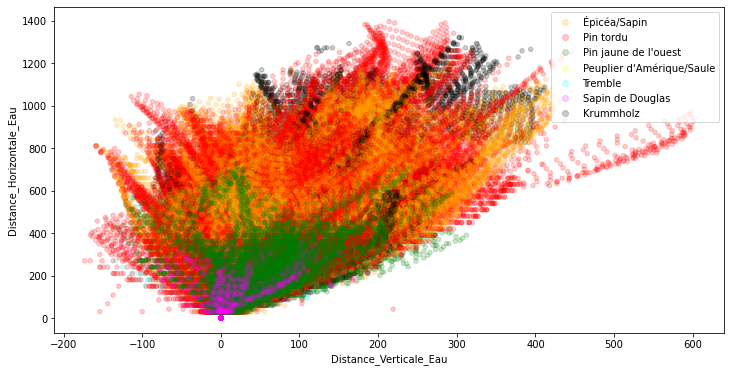

In [12]:
graphe_dispersion(tableau, "Distance_Verticale_Eau", "Distance_Horizontale_Eau")

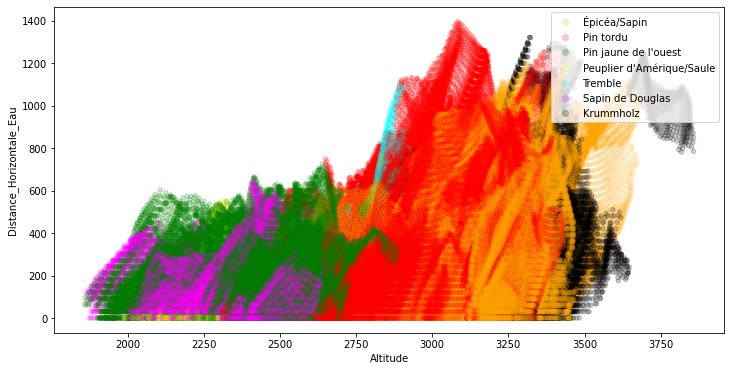

In [13]:
graphe_dispersion(tableau, "Altitude", "Distance_Horizontale_Eau")

## 3. Première approche

### 3.1. Réduction du problème

In [14]:
tableau_min = pandas.concat(objs=[
    tableau[tableau["Type_Couvert"].isin([0])].sample(n=100),
    tableau[tableau["Type_Couvert"].isin([5])].sample(n=100)],
    axis=0).sample(frac=1)[[
        "Altitude",
        "Distance_Feu",
        "Type_Couvert"
    ]]
tableau_min

,Altitude,Distance_Feu,Type_Couvert
444487,3151,875,0
578294,2429,1127,5
427106,3399,2281,0
295041,2437,1148,5
6012,2376,1144,5
...,...,...,...
249680,3037,1913,0
281446,2298,866,5
551010,3290,3691,0
302320,2478,1343,5


In [15]:
X = tableau_min[["Altitude", "Distance_Feu"]]
reducteur = StandardScaler().fit(X)
X_reduit = reducteur.transform(X)
y = tableau_min["Type_Couvert"] // 5
X

,Altitude,Distance_Feu
444487,3151,875
578294,2429,1127
427106,3399,2281
295041,2437,1148
6012,2376,1144
...,...,...
249680,3037,1913
281446,2298,866
551010,3290,3691
302320,2478,1343


In [16]:
y

444487    0
578294    1
427106    0
295041    1
6012      1
         ..
249680    0
281446    1
551010    0
302320    1
266379    1
Name: Type_Couvert, Length: 200, dtype: int64

### 3.2. Le Perceptron

In [17]:
def escalier(z):
    if z.shape[0] > 1:
        return (z > 0).astype(int)[:, 0]
    return 1.0 if (z > 0) else 0.0

class Perceptron:

    def __init__(self):
        self.theta = numpy.zeros((3, 1))

    def __sklearn_is_fitted__(self):
        return True

    def fit(self, X, y, learning_rate=1, epochs=1):
        for epoch in range(epochs):
            for idx, x_i in enumerate(X):
                x_i = numpy.insert(x_i, 0, 1).reshape(-1, 1)
                y_hat = escalier(numpy.dot(x_i.T, self.theta))
                if (numpy.squeeze(y_hat) - y.iloc[idx]) != 0:
                    self.theta += learning_rate * ((y.iloc[idx] - y_hat) * x_i)
        return self
    
    def predict(self, X):
        z = numpy.insert(X, 0, 1, axis=1)
        return escalier(numpy.dot(z, self.theta))
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return 1 - numpy.abs(y_hat - y).sum() / y.shape[0]

Précision : 94.5%


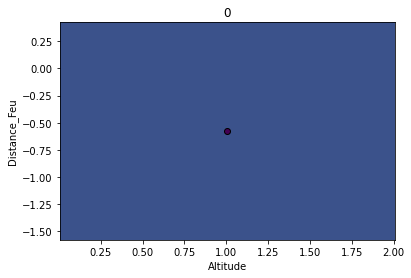

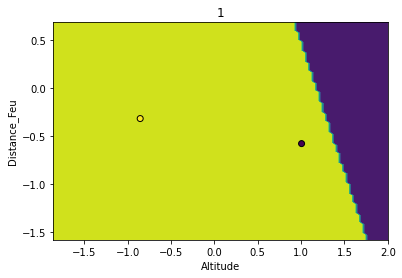

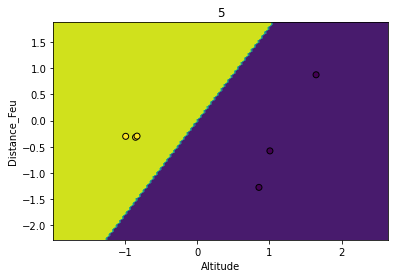

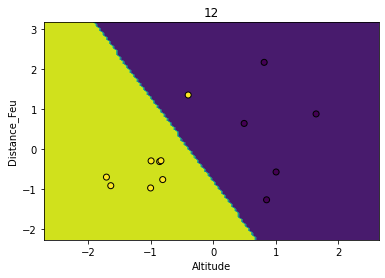

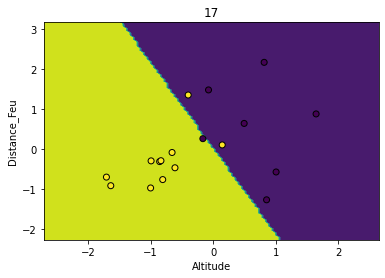

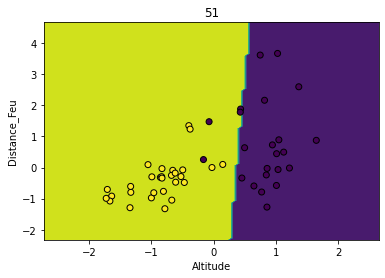

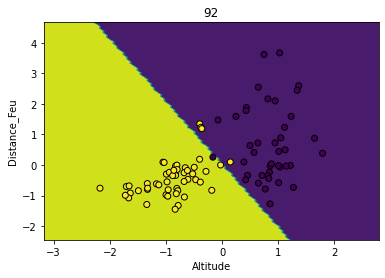

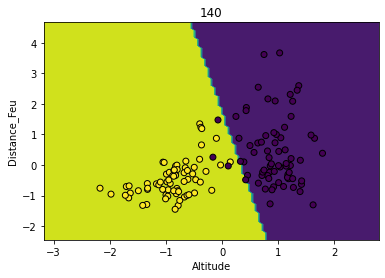

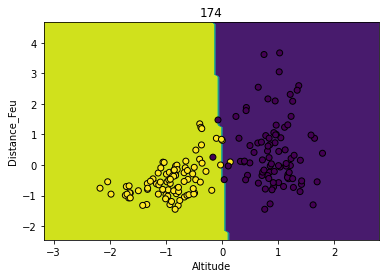

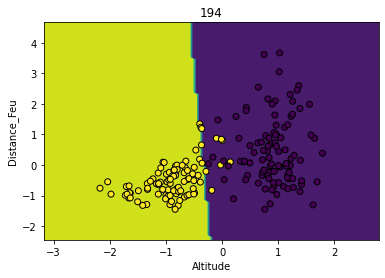

In [18]:
modele = Perceptron()

points = []
for idx, x_i in enumerate(X_reduit):
    points.append(x_i)  
    x_i = numpy.insert(x_i, 0, 1).reshape(-1, 1)
    y_hat = escalier(numpy.dot(x_i.T, modele.theta))
    change = False
    if (numpy.squeeze(y_hat) - y.iloc[idx]) != 0:
        modele.theta += 0.1 * ((y.iloc[idx] - y_hat) * x_i)
        change = True
    if idx == 0 or change:
        points_numpy = numpy.array(points)
        dessin = DecisionBoundaryDisplay.from_estimator(
            modele,
            points_numpy,
            response_method="predict")
        dessin.ax_.scatter(
            points_numpy[:, 0],
            points_numpy[:, 1],
            c=tableau_min["Type_Couvert"][:idx + 1],
            edgecolors="k")
        dessin.ax_.set_xlabel("Altitude")
        dessin.ax_.set_ylabel("Distance_Feu")
        dessin.ax_.set_title(idx)

print("Précision : %.1f%%" % (modele.score(X_reduit, y) * 100))

### 3.3. Séparation des données d'entraînement et de test

Score d'entraînement : 87.0%
Score de test : 65.8%


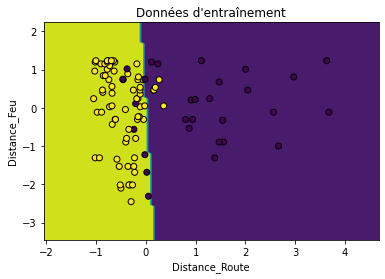

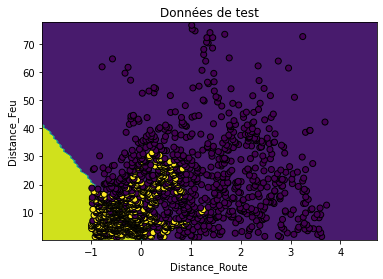

In [19]:
seuil = 100

tableau_med = pandas.concat(objs=[
    tableau[tableau["Type_Couvert"].isin([0])].sample(n=1000),
    tableau[tableau["Type_Couvert"].isin([5])].sample(n=1000)],
    axis=0).sample(frac=1)[[
        "Distance_Route",
        "Distance_Feu",
        "Type_Couvert"]]
tableau_med = tableau_med.sort_values(by=["Distance_Feu"])
X_entrainement = tableau_med[["Distance_Route", "Distance_Feu"]][:seuil]
X_test = tableau_med[["Distance_Route", "Distance_Feu"]][seuil:]
reducteur = StandardScaler().fit(X_entrainement)
X_entrainement_reduit = reducteur.transform(X_entrainement)
X_test_reduit = reducteur.transform(X_test)
y_entrainement = tableau_med["Type_Couvert"][:seuil] // 5
y_test = tableau_med["Type_Couvert"][seuil:] // 5

modele = Perceptron()
modele.fit(X_entrainement_reduit, y_entrainement, epochs=100)

dessin = DecisionBoundaryDisplay.from_estimator(modele, X_entrainement_reduit, response_method="predict")
dessin.ax_.scatter(X_entrainement_reduit[:, 0], X_entrainement_reduit[:, 1], c=y_entrainement, edgecolors="k")
dessin.ax_.set_xlabel("Distance_Route")
dessin.ax_.set_ylabel("Distance_Feu")
dessin.ax_.set_title("Données d'entraînement")
print("Score d'entraînement : %.1f%%" % (modele.score(X_entrainement_reduit, y_entrainement) * 100))

dessin = DecisionBoundaryDisplay.from_estimator(modele, X_test_reduit, response_method="predict")
dessin.ax_.scatter(X_test_reduit[:, 0], X_test_reduit[:, 1], c=y_test, edgecolors="k")
dessin.ax_.set_xlabel("Distance_Route")
dessin.ax_.set_ylabel("Distance_Feu")
dessin.ax_.set_title("Données de test")
print("Score de test : %.1f%%" % (modele.score(X_test_reduit, y_test) * 100))

## 4. Retour au cas réel

In [20]:
tableau_entrainement = tableau.drop(columns=["Sol", "Zone"])[:15000].sample(frac=1)
tableau_test = tableau.drop(columns=["Sol", "Zone"])[15000:].sample(frac=1)

In [21]:
modele = DecisionTreeClassifier(max_depth=5)
modele.fit(
    tableau_entrainement.drop(columns=["Type_Couvert"]),
    tableau_entrainement["Type_Couvert"])

print("Précision d'entraînement : %.1f%%" % (modele.score(
    tableau_entrainement.drop(columns=["Type_Couvert"]),
    tableau_entrainement["Type_Couvert"]) * 100))
print("Précision de test : %.1f%%" % (modele.score(
    tableau_test.drop(columns=["Type_Couvert"]),
    tableau_test["Type_Couvert"]) * 100))

Précision d'entraînement : 66.4%
Précision de test : 43.9%


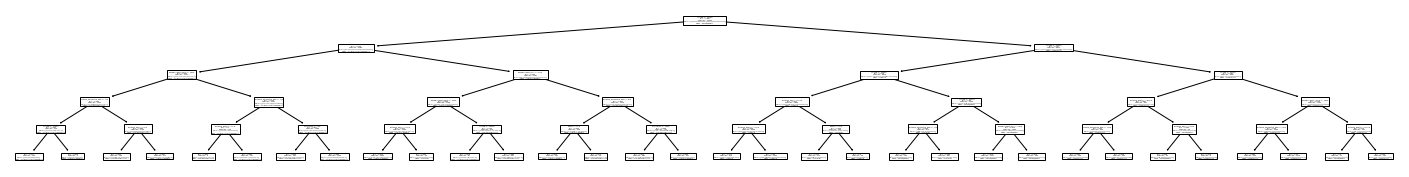

In [22]:
matplotlib.pyplot.figure(figsize=(25, 3))
tree.plot_tree(modele, feature_names=tableau_entrainement.drop(columns=["Type_Couvert"]).columns, class_names=CLASSES)
matplotlib.pyplot.savefig("arbre_de_decision.svg")
pass

## 5. Ingénierie des *features*

### 5.1. Enrichissement des données

In [23]:
valeur_zone_climatique = {
    "Alpin": 7,
    "Subalpin": 6,
    "Montagnard et Subalpin": 5,
    "Montagnard sec": 2,
    "Montagnard sec et Montagnard": 3,
    "Montagnard": 2,
    "Basse montagne": 1,
}

valeur_surface = {
    "Gravats": 1,
    "Caillouteux": 2,
    "Très caillouteux": 3,
    "Extrêmement caillouteux": 4,
}

valeur_taille_roche = {
    "Gravats": 1,
    "Pierres": 2,
    "Rochers": 3
}

types_de_sol = pandas.read_csv("input/sols.tsv", delimiter="\t").set_index("id").drop(columns=["source", "ELU", "nom"])

encodeur_zone_geologique = LabelEncoder()
types_de_sol["zone_geologique"] = encodeur.fit_transform(types_de_sol["zone_geologique"])

def manual_encoding(df, column, encoding):
    new_column = []
    for index, row in df.iterrows():
        if pandas.isna(row[column]):
            new_column.append(0)
        else:
            new_column.append(encoding[row[column]])
    df[column] = new_column

manual_encoding(types_de_sol, "zone_climatique", valeur_zone_climatique)
manual_encoding(types_de_sol, "surface", valeur_surface)
manual_encoding(types_de_sol, "taille_roche", valeur_taille_roche)

tableau_enrichi = tableau.join(types_de_sol, on="Sol")
tableau_enrichi

,Altitude,Orientation,Pente,Distance_Horizontale_Eau,Distance_Verticale_Eau,Distance_Route,Ensoleillement_Matin,Ensoleillement_Midi,Ensoleillement_Aprem,Distance_Feu,Type_Couvert,Sol,Zone,zone_climatique,zone_geologique,surface,taille_roche
0,2596,51,3,258,0,510,221,232,148,6279,4,29,1,6,2,4,2
1,2590,56,2,212,-6,390,220,235,151,6225,4,29,1,6,2,4,2
2,2804,139,9,268,65,3180,234,238,135,6121,1,12,1,2,2,2,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,30,1,6,2,4,2
4,2595,45,2,153,-1,391,220,234,150,6172,4,29,1,6,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,2,2,3,1,2,3,2
581008,2391,152,19,67,12,95,240,237,119,845,2,2,3,1,2,3,2
581009,2386,159,17,60,7,90,236,241,130,854,2,2,3,1,2,3,2
581010,2384,170,15,60,5,90,230,245,143,864,2,2,3,1,2,3,2


### 5.2. Évaluation du nouveau modèle

In [24]:
tableau_entrainement = tableau_enrichi[:15000].sample(frac=1)
tableau_test = tableau_enrichi[15000:].sample(frac=1)

modele = DecisionTreeClassifier()
modele.fit(tableau_entrainement.drop(columns=["Type_Couvert"]), tableau_entrainement["Type_Couvert"])

print("Précision d'entraînement : %.1f%%" % (modele.score(
    tableau_entrainement.drop(columns=["Type_Couvert"]),
    tableau_entrainement["Type_Couvert"]) * 100))
print("Précision de test : %.1f%%" % (modele.score(
    tableau_test.drop(columns=["Type_Couvert"]),
    tableau_test["Type_Couvert"]) * 100))

Précision d'entraînement : 100.0%
Précision de test : 66.3%
